In [1]:
import os
import sys
%load_ext autoreload
%autoreload 2
sys.path.append('..')

import numpy as np
import random
import torch
# %env CUDA_VISIBLE_DEVICES=1

from lib import data_processors, utils

In [2]:
params = {
    'data_dir': '../../data/SST-2',
    'output_dir': '../output',
    'cache_dir': '../model_cache',
    'task_name': 'sst2',
    'bert_model': 'bert-base-uncased',
    'max_seq_length': 128,
    'train_batch_size': 32,
    'eval_batch_size': 8,
    'learning_rate': 2e-5,
    'warmup_proportion': 0.1,
    'num_train_epochs': 1,
    'seed': 1331
}

processors = {
    'cola': data_processors.ColaProcessor,
    'mnli': data_processors.MnliProcessor,
    'mrpc': data_processors.MrpcProcessor,
    'sst2': data_processors.SST2Processor
}

num_labels_task = {
    'cola': 2,
    'mnli': 3,
    'mrpc': 2,
    'sst2': 2
}

random.seed(params['seed'])
np.random.seed(params['seed'])
torch.manual_seed(params['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from lib.bert import BertForSequenceClassification
from pytorch_pretrained_bert.tokenization import BertTokenizer

from lib.train_eval import train, evaluate

from lib.train_student import train_student, eval_teacher_soft_targets

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
processor = processors[params['task_name']]()
num_labels = num_labels_task[params['task_name']]
label_list = processor.get_labels()

tokenizer = BertTokenizer.from_pretrained(
    params['bert_model'], do_lower_case=True)

train_examples = processor.get_train_examples(params['data_dir'])
eval_examples = processor.get_dev_examples(params['data_dir'])

# teacher_model = BertForSequenceClassification.from_pretrained(
#     params['bert_model'], cache_dir=params['cache_dir'], num_labels=num_labels).to(device)

04/25/2019 13:58:14 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/shakhrayv/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [5]:
from pytorch_pretrained_bert.modeling import (BertConfig, WEIGHTS_NAME, CONFIG_NAME)

# Load a trained model and config that you have fine-tuned
config = BertConfig(os.path.join(params['output_dir'], CONFIG_NAME))
teacher_model = BertForSequenceClassification(config, num_labels=num_labels)
teacher_model.load_state_dict(torch.load(os.path.join(params['output_dir'], WEIGHTS_NAME)))
teacher_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertInterme

Скачиваем студента.

In [7]:
from lib.blend_cnn import BlendCNN

model = BlendCNN(params['max_seq_length'], len(tokenizer.vocab), len(label_list), n_layers=6).to(device)

In [7]:
# model = BertForSequenceClassification.from_pretrained(
#     params['bert_model'], cache_dir=params['cache_dir'], num_labels=num_labels).to(device)


# all_layers = model.bert.encoder.layer
# model.bert.encoder.layer = all_layers[3:9]

04/12/2019 16:21:13 - INFO - lib.bert -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at ../model_cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
04/12/2019 16:21:13 - INFO - lib.bert -   extracting archive file ../model_cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmp07jmnj78
04/12/2019 16:21:15 - INFO - lib.bert -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

04/12/2019 16:21:17 - INFO - lib.bert -   Weights of BertForSequenceClassification not initi

In [9]:
# compute soft logits from teacher
from lib.train_student import eval_teacher_soft_targets
from torch.utils.data import TensorDataset


train_features = utils.convert_examples_to_features(train_examples, label_list, 
                                                    params['max_seq_length'], tokenizer)

all_input_ids = torch.tensor([f.input_ids for f in train_features],
                         dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features],
                          dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features],
                           dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in train_features],
                         dtype=torch.long)

eval_teacher_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

all_logits_teacher = eval_teacher_soft_targets(teacher_model, eval_teacher_dataset, label_list, params)

Evaluating: 100%|██████████| 2105/2105 [03:13<00:00, 10.86it/s]


In [50]:
params['train_batch_size'] = 32
params['num_train_epochs'] = 3

In [ ]:
a = 10

In [ ]:
from itertools import product
import pickle

Ts = [1, 2, 3, 4, 6, 8, 12, 15, 20]
# alphas = np.linspace(0.1, 0.9, 9)
alphas = np.linspace(0, 1, 6)

different_params = product(Ts, alphas)
# all_result_parameters2 = []

for param in list(different_params)[23:]:
    cur_result = []
    
    model = BertForSequenceClassification.from_pretrained(
    params['bert_model'], cache_dir=params['cache_dir'], num_labels=num_labels).to(device)
    all_layers = model.bert.encoder.layer
    model.bert.encoder.layer = all_layers[3:9]

#     model = BlendCNN(params['max_seq_length'], len(tokenizer.vocab), len(label_list), n_layers=6).to(device)
    
    cur_result.append(param)
    
    result = train_student(model, teacher_model, train_examples, label_list, params, 
                           tokenizer, all_logits_teacher=all_logits_teacher, temperature=param[0], alpha=param[1])
    
    cur_result.append(result)
    result = evaluate(model, eval_examples, label_list, params, tokenizer)
    cur_result.append(result)
    all_result_parameters2.append(cur_result)
    
    with open('all_result_parameters2.pickle', 'wb') as file:
        pickle.dump(all_result_parameters2, file)
    
    print('T = {}, alpha = {}, \n {}, {}'.format(cur_result[0][0], cur_result[0][1], cur_result[1], cur_result[2]))

04/27/2019 11:32:56 - INFO - lib.bert -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at ../model_cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
04/27/2019 11:32:56 - INFO - lib.bert -   extracting archive file ../model_cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpn14u3spi
04/27/2019 11:32:58 - INFO - lib.bert -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

04/27/2019 11:33:01 - INFO - lib.bert -   Weights of BertForSequenceClassification not initi

***** Running training *****
Num examples: 67349
Batch size:   32
Num steps:    6312
Epoch: 1


Iteration:   0%|          | 1/2105 [00:00<06:07,  5.73it/s]

Epoch: 2


Iteration:   0%|          | 1/2105 [00:00<06:09,  5.69it/s]

Epoch: 3


Iteration: 100%|██████████| 2105/2105 [06:06<00:00,  6.21it/s]
04/27/2019 11:51:25 - INFO - lib.train_eval -   ***** Running evaluation *****
04/27/2019 11:51:25 - INFO - lib.train_eval -     Num examples = 872
04/27/2019 11:51:25 - INFO - lib.train_eval -     Batch size = 8
Evaluating: 100%|██████████| 109/109 [00:03<00:00, 35.13it/s]
04/27/2019 11:51:29 - INFO - lib.train_eval -   ***** Eval results *****
04/27/2019 11:51:29 - INFO - lib.train_eval -     eval_accuracy = 0.8967889908256881
04/27/2019 11:51:29 - INFO - lib.train_eval -     eval_loss = 0.3154225428375082


T = 1, alpha = 0.0, 
 {'loss': 0.0766587750623423, 'global_step': 6315}, {'eval_loss': 0.3154225428375082, 'eval_accuracy': 0.8967889908256881}


04/27/2019 11:51:30 - INFO - lib.bert -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at ../model_cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
04/27/2019 11:51:30 - INFO - lib.bert -   extracting archive file ../model_cache/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmp9zozbs87
04/27/2019 11:51:32 - INFO - lib.bert -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

04/27/2019 11:51:34 - INFO - lib.bert -   Weights of BertForSequenceClassification not initi

***** Running training *****
Num examples: 67349
Batch size:   32
Num steps:    6312
Epoch: 1


Iteration:   0%|          | 1/2105 [00:00<06:09,  5.69it/s]

Epoch: 2


Iteration:  47%|████▋     | 988/2105 [02:52<03:14,  5.74it/s]

In [41]:
len(all_result_parameters_blendcnn), len(all_result_parameters_blendcnn2), len(all_result_parameters_blendcnn3)

(66, 66, 66)

In [38]:
len(all_result_parameters)

66

In [48]:
len(all_result_parameters_blendcnn4)

66

In [39]:
all_result_parameters

[[(1, 0.0),
  {'loss': 0.07828958881200422, 'global_step': 6315},
  {'eval_loss': 0.29250557177247255, 'eval_accuracy': 0.9128440366972477}],
 [(1, 0.2),
  {'loss': 0.0656344429722538, 'global_step': 6315},
  {'eval_loss': 0.30241677851988635, 'eval_accuracy': 0.9071100917431193}],
 [(1, 0.4),
  {'loss': 0.05415815982487575, 'global_step': 6315},
  {'eval_loss': 0.28180991769383806, 'eval_accuracy': 0.911697247706422}],
 [(1, 0.6000000000000001),
  {'loss': 0.04202867837267709, 'global_step': 6315},
  {'eval_loss': 0.28204828476823796, 'eval_accuracy': 0.9071100917431193}],
 [(1, 0.8),
  {'loss': 0.030600112932236453, 'global_step': 6315},
  {'eval_loss': 0.2856803314948301, 'eval_accuracy': 0.911697247706422}],
 [(1, 1.0),
  {'loss': 0.018639968978899205, 'global_step': 6315},
  {'eval_loss': 0.2973384428598465, 'eval_accuracy': 0.9036697247706422}],
 [(2, 0.0),
  {'loss': 0.07704000293925369, 'global_step': 6315},
  {'eval_loss': 0.26965486480418693, 'eval_accuracy': 0.91055045871559

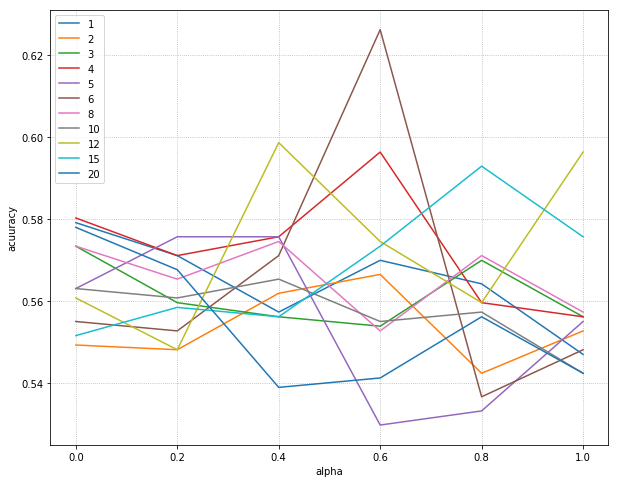

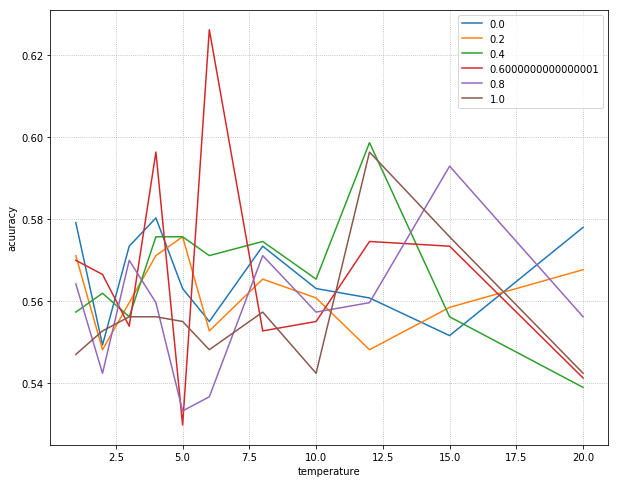

In [49]:
from collections import defaultdict
import matplotlib.pyplot as plt

T_scores = defaultdict(lambda : [])
alpha_scores = defaultdict(lambda : [])

# for res1, res2, res3 in zip(all_result_parameters_blendcnn, all_result_parameters_blendcnn2, all_result_parameters_blendcnn3):
#     print(res1[2]['eval_accuracy'], res2[2]['eval_accuracy'], res3[2]['eval_accuracy'])
#     T_scores[res1[0][0]].append((res1[2]['eval_accuracy'] + res2[2]['eval_accuracy'] + res3[2]['eval_accuracy']) / 3)
#     alpha_scores[res1[0][1]].append((res1[2]['eval_accuracy'] + res2[2]['eval_accuracy'] + res3[2]['eval_accuracy']) / 3)
    
for res in all_result_parameters_blendcnn:
    T_scores[res[0][0]].append(res[2]['eval_accuracy'])
    alpha_scores[res[0][1]].append(res[2]['eval_accuracy'])
    
    
plt.figure(figsize=(10, 8))
for T in T_scores.keys():
    plt.plot(alphas, T_scores[T], label=str(T))
    
plt.xlabel('alpha')
plt.ylabel('acuuracy')
plt.grid(ls=':')
plt.legend()
plt.show();

plt.figure(figsize=(10, 8))
for alpha in alpha_scores.keys():
    plt.plot(Ts, alpha_scores[alpha], label=str(alpha))
    
plt.xlabel('temperature')
plt.ylabel('acuuracy')
plt.grid(ls=':')
plt.legend()
plt.show();

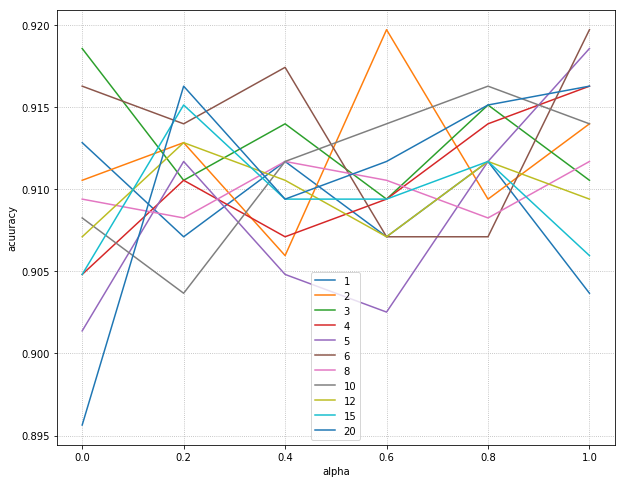

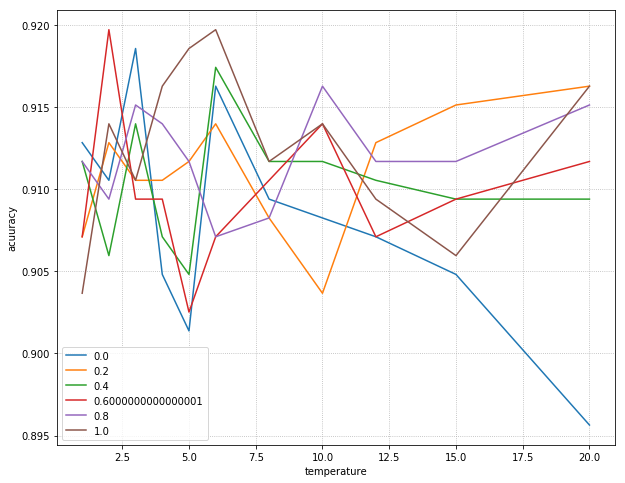

In [45]:
from collections import defaultdict
import matplotlib.pyplot as plt

T_scores = defaultdict(lambda : [])
alpha_scores = defaultdict(lambda : [])

for res in all_result_parameters:
    T_scores[res[0][0]].append(res[2]['eval_accuracy'])
    alpha_scores[res[0][1]].append(res[2]['eval_accuracy'])
    
plt.figure(figsize=(10, 8))
for T in T_scores.keys():
    plt.plot(alphas, T_scores[T], label=str(T))
    
plt.xlabel('alpha')
plt.ylabel('acuuracy')
plt.grid(ls=':')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
for alpha in alpha_scores.keys():
    plt.plot(Ts, alpha_scores[alpha], label=str(alpha))
    
plt.xlabel('temperature')
plt.ylabel('acuuracy')
plt.grid(ls=':')
plt.legend()
plt.show()